<a href="https://colab.research.google.com/github/Navneet-Nicer/Book-Recommendation-System/blob/main/Unsupervised_ML_Book_Recommendation_System3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <font size="+2" color='#053c96'><b> Project Name </b></font> - $\color{red}{\text{Book Recommendation System}}$

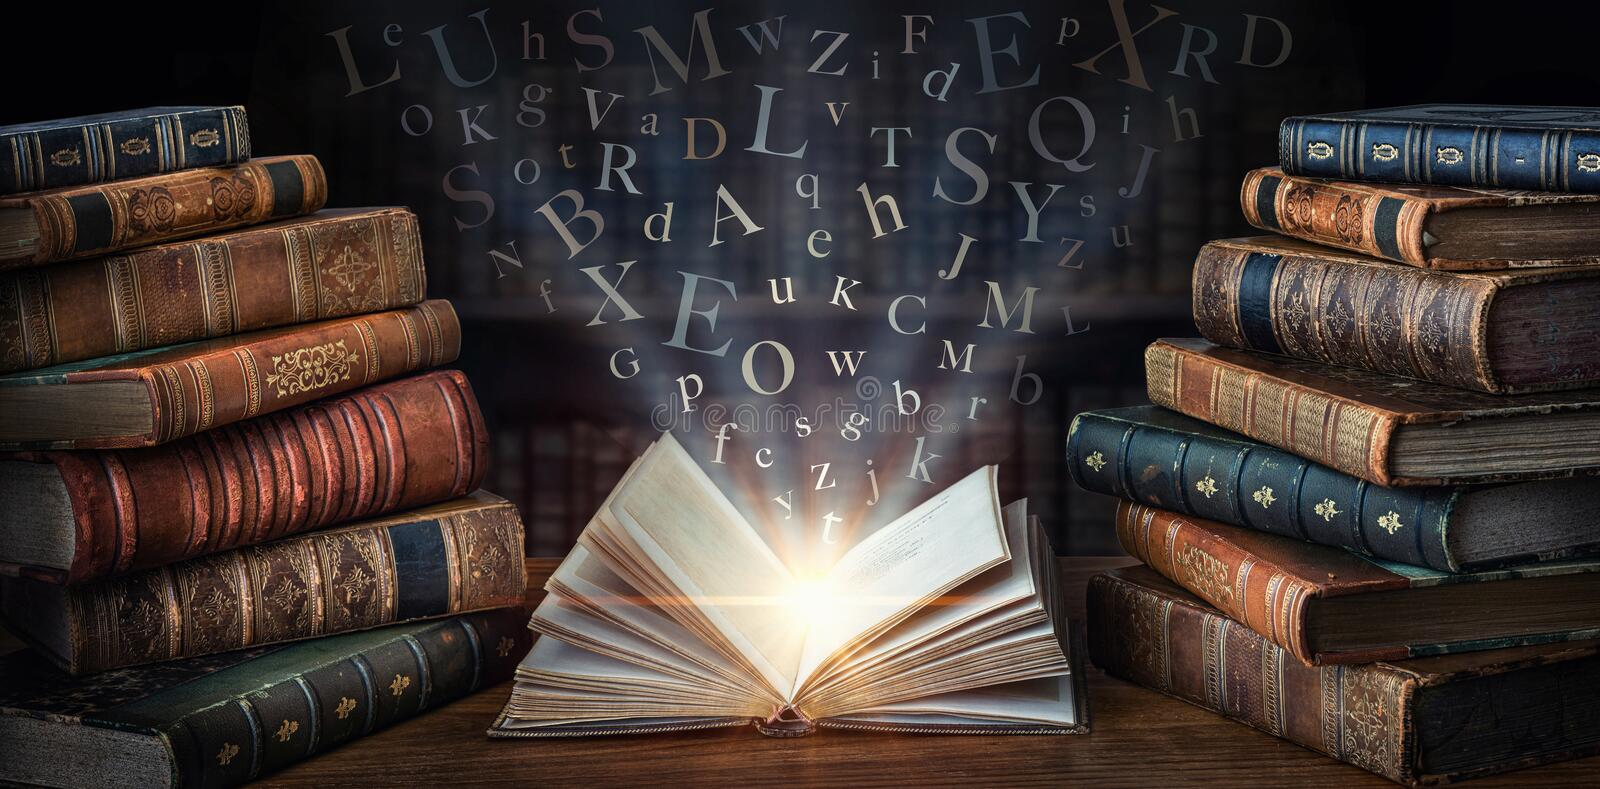

##### **Project Type**    - Unsupervised ML
##### **Contribution**    - Individual
##### **Team Member** -  $\color{green}{\text{Navneet Singh}}$


**GitHub Link**

https://github.com/Naveen-King/Book-Recommendation-System

**Dataset Overview:**

**Context**

Here we have a set of 3 datasets which contains:

Books data :
Giving the detail overview about the book information including the book title, publication year, as well as the author of the book

Users data :
Give the detailed overview about each user such as the user's location as well as the user's age

Rating data :
Basically compiled data about how each user rated each books

**Educational use of the dataset**

This dataset is a simple data which does not require much data cleaning. The rich information provided about the books, users, as well as the rating makes these data a good candidate to practice recommendation algorithm. Despite missing several details that can potentially makes it ideal, it is still sufficient enough.

**Personal Goal and Motivation for this notebook**

In this notebook, the motivation is to:

* Preprocess several dataset in relation to book data and rating data
* Create recommendation algorithm to recommend book to certain user
* 1st model: Content-based recommendation
* 2nd model: Collaborative recommendation

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import missingno as msno

**Loading Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Books Data**

In [3]:
# Read in the datasets
df_books = pd.read_csv("/content/drive/MyDrive/Capstone Project/Books.csv", delimiter=",",usecols = [0,1,2,3,4])

<ipython-input-3-29a5f68cf7e5>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv("/content/drive/MyDrive/Capstone Project/Books.csv", delimiter=",",usecols = [0,1,2,3,4])


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Based on the info above, we can see that Year-of-publication is stated as object. I believe that this is not the correct format and we need to put it into integer

In [5]:
try:
    df_books['Year-Of-Publication']  = df_books['Year-Of-Publication'].astype(int)
except Exception as e:
    print(e)

invalid literal for int() with base 10: 'DK Publishing Inc'


invalid literal for int() with base 10: 'DK Publishing Inc'

Oops! There is a data point in which the Years of Publication is filled with the publisher. Let us see the data

In [6]:
df_books[df_books['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


We can see that the book above is shifted. I believe that this is a formatting problem.


Cleaning up the data one by one can take a lot of effort. So, for now, we will just delete data points which are wrongly formatted.


We can catch this by trying to convert the Year-of-publication into numerical value and coerce the conversion. The data that can not be converted into numerical value will be replaced by NaN value which will be then removed by dropna() function of pandas.

In [7]:
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'],errors='coerce')

In [8]:
df_books = df_books.dropna()
df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)

<ipython-input-8-cdbc1c10f2fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)


In [9]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


The formatting went well. Now let us see how book is distributed among the publication year!

<BarContainer object of 116 artists>

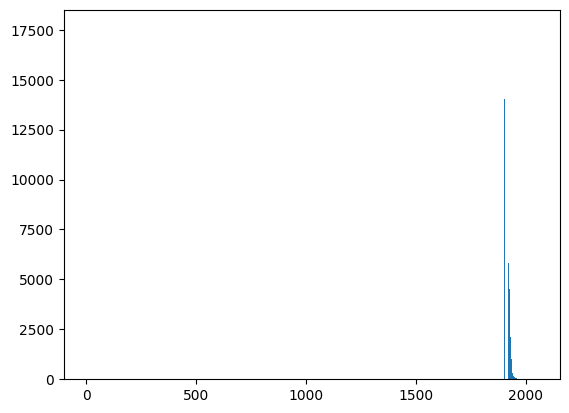

In [10]:
plt.bar(pd.DataFrame(df_books['Year-Of-Publication'].value_counts()).sort_index().index, np.array(df_books['Year-Of-Publication'].value_counts()), width = 1)

The histogram above showed us 2 things:

* Most of the books published in year 1700~2000s
* It is clear that there are some books with publication year below 500s. I believe that this is an error of input
  * It can be a good practice to replace these books with correct information. In the case of missing value, we can impute the number with mean or mode. However, I do not believe it will change the result much in this case. Therefore, I will just leave it as it is for now
  
That concludes the preprocessing for the book data. Let us move to the users data!

**Users Data**

In [11]:
df_Users = pd.read_csv("/content/drive/MyDrive/Capstone Project/Books_Users.csv")

In [12]:
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Let us check for the missing values in the user data

<Axes: >

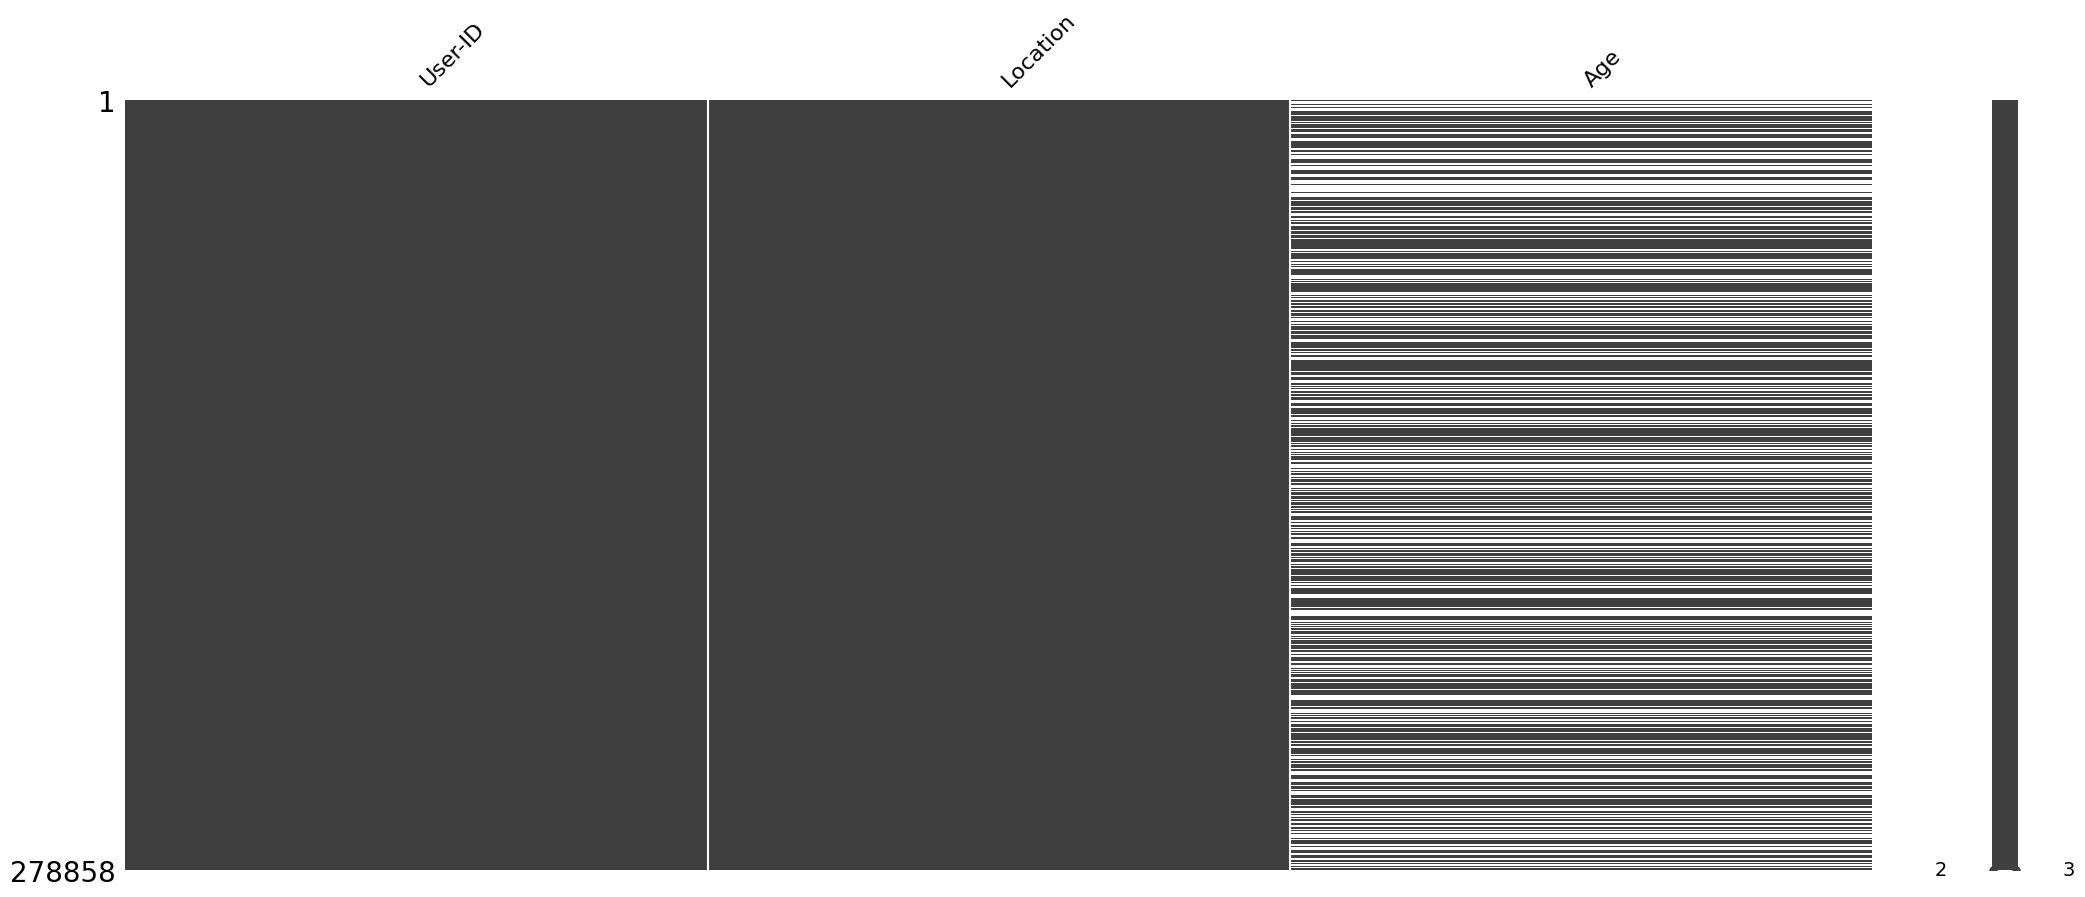

In [13]:
msno.matrix(df_Users)

Looking at the age data, we can see that about many data are missing from the age column (to be precise: 110762 data).

Since we are going to use content-based filtering based on the book information and not based on the user information, we can leave the missing value as it is for now.

In this case, we will only use this phase to grasp the information provided by the User data. However, we will not perform any preprocessing on the user data.

**Rating Data**

We have preprocessed the books and the users. Now, we will keep in mind the books and users that we exclude from the previous data cleaning and we will also reflect it to the rating data.

First, we will load the data

In [14]:
df_rating = pd.read_csv("/content/drive/MyDrive/Capstone Project/Books_Ratings.csv")

In [15]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


From the rating data, we can see that we have 3 columns as follows:

* User-ID: The User ID. This one is unique for each user
* ISBN : some sort of the ID for the book being read by the user
* Rating: Ratings given by the user for the book.
The sample above showed that user 276725 has given book with ISBN 034545104X a rating of 0.

We can also observed that the data contains around 1 million data. This can be very burdensome to our analysis. For that reason, I will try to clean our data. The details for cleaning will be explained in the section below.

**Data Cleaning**

We will begin our cleaning phase by deleting the data points that contains books and user-ID that we deleted in the previous sections

In [16]:
print('Number of data before cleaning : {}'.format(len(df_rating)))
df_rating = df_rating[df_rating['ISBN'].isin(df_books['ISBN'])]
print('Number of data after cleaning : {}'.format(len(df_rating)))

Number of data before cleaning : 1149780
Number of data after cleaning : 1031129


We can clean the data further by reducing some noise.

In real life, when we are dealing with rating data, there are some users that doesn't rate certain books. On the other side, there are some books which are not rated by several user.

These data are called sparse data in which data contains mostly zero or null values. In real-world, ratings can be very sparse and data points will mostly be collected from either:

* A very popular book
or a highly engaging user
* A book that are rated highly but only have 1 or 2 users who rated the book are hardly credible.

On the other hand, user that only rated 1 or two book are hardly a credible user. Therefore, we need to clean the data by introducing filter with below criteria:

* For a book to be credible, it requres ate least votes from 10 users
* For a user to be credible, the user must have voted at least 50 books
This filter might also help us in minimizing the number of the data as well as reducing memory used in this analysis

In [17]:
f = ['count','mean']

df_books_summary = df_rating.groupby('ISBN')['Book-Rating'].agg(f)
df_books_summary.index = df_books_summary.index.map(str)

drop_book_list = df_books_summary[df_books_summary['count'] < 10].index

df_cust_summary = df_rating.groupby('User-ID')['Book-Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)

drop_cust_list = df_cust_summary[df_cust_summary['count'] < 10].index

In [18]:
print('Before Filtering: {}'.format(df_rating.shape))
df_rating = df_rating[~df_rating['ISBN'].isin(drop_book_list)]
df_rating = df_rating[~df_rating['User-ID'].isin(drop_cust_list)]
print('After Filtering: {}'.format(df_rating.shape))

Before Filtering: (1031129, 3)
After Filtering: (428085, 3)


In [19]:
pivot_rating = df_rating.pivot(index='ISBN',columns='User-ID',values='Book-Rating')
pivot_rating.head()

User-ID,8,99,242,243,254,383,388,408,424,446,...,278522,278535,278554,278563,278582,278633,278637,278771,278843,278851
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002251760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002255081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002257203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002259834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Building Recommendation Model**

**Content-based Recommendation**

Content-based collaborative recommendation works by looking at a certain product that a user has liked or rated highly in the past then proceeds to recommend a product that is similar to the highly-rated product.

In this notebook, I will try to make a function that requires us to input the user-ID.

The algorithm then will proceed to find the highest-rated book by the user and then recommend several other books that are similar to the highest-rated book

**Content-based recommendation based on the author and publisher of the book**

This recommendation is made based on an assumption that a certain reader will be attracted to read another book based factors below:

* authors Some readers might be attracted to some certain authors because some authors tends to write about a specific genre that certain demographic of reader like. So, including auhtor as one of the factor might be plausible.

* year-of-publication Year of publication might reflect some kind of genre preferred by readers (e.g. reader who would like to read classical philosophy books might tend to read older books compared to new ones).

* publisher Certain publisher has a certain kind of credibility which might make some book readers prefer one publisher compared to other.

Based on that consideration, we will consider Author, Year of publication, as well as publisher as basis for recommendation.

In [20]:
len(df_books['ISBN'].unique())

271354

There are around 270000 different books based on what we have in this dataset. For now, we will limit the recommendation only for books that are considered credible based on our definition when we clean the data. Hence, we will only pick books featured in the df_rating dataframe.

After cleaning, we are left with:

In [21]:
print ("number of books: " + str(len(df_books[df_books['ISBN'].isin(df_rating['ISBN'].unique())].copy())))

number of books: 17478


only around 17359 books.

Keep in mind that in real-life scenario we would like to have as many sample as possible.

In [22]:
features = ['Book-Author', 'Year-Of-Publication', 'Publisher']

df_books_preprocess = df_books[df_books['ISBN'].isin(df_rating['ISBN'].unique())].copy()


for feature in features:
    if df_books_preprocess[feature].dtype == 'O':
        df_books_preprocess[feature]=df_books_preprocess[feature].str.replace('\W', '', regex=True)
        df_books_preprocess[feature] =  df_books_preprocess[feature].apply(lambda x: str.lower(x))

In [23]:
def create_soup(x):
    return x['Book-Author'] + ' ' + str(x['Year-Of-Publication'])+ ' ' + x['Publisher']

df_books_preprocess['soup'] = df_books_preprocess[features].apply(create_soup, axis = 1)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_books_preprocess['soup'])

In [25]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [26]:
df2 = df_books_preprocess.reset_index()
indices = pd.Series(df2.index, index=df2['ISBN'])

In [27]:
def recommend_books(ISBN, cosine_sim):
    # Get the index of the books that matches the ISBN
    idx = indices[ISBN]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return df2[['Book-Title','soup']].iloc[book_indices], sim_scores

def get_recommendations(userid, cosine_sim):
    #userid = str(userid)
    ISBN = df_rating['ISBN'].loc[df_rating[df_rating['User-ID'] == userid]['Book-Rating'].idxmax()]

    recommendation, sim_score = recommend_books(ISBN, cosine_sim)

    df_recommend = pd.DataFrame(recommendation)
    df_recommend['Cosine_Similarity'] = sim_score
    df_recommend['Cosine_Similarity'] = df_recommend['Cosine_Similarity'].apply(lambda x: x[1])

    return df_recommend

We will try to make some recommendation for User-ID 8.

First, let us check which books read by User-ID 8

In [28]:
pd.concat([df_books[df_books['ISBN'].isin(list(df_rating[df_rating['User-ID'] == 8]['ISBN']))].reset_index(drop=True),df_rating[df_rating['User-ID'] == 8]['Book-Rating'].reset_index(drop=True)], axis = 1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,0
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,0


User-ID 8 read 3 books and among them, He rated Clara Callan the highest. Therefore, we will recommend some books for User-ID 8!

In [29]:
df_recommend = get_recommendations(8, cosine_sim2)
df_recommend

,Book-Title,soup,Cosine_Similarity
15353,Spadework,timothyfindley 2001 harperflamingocanada,0.666667
6,New Vegetarian: Bold and Beautiful Recipes for...,celiabrooksbrown 2001 rylandpetersampsmallltd,0.333333
19,From the Corner of His Eye,deankoontz 2001 bantambooks,0.333333
44,El Senor De Los Anillos: LA Comunidad Del Anil...,jrrtolkien 2001 minotauro,0.333333
45,El Senor De Los Anillos: Las DOS Torres (Lord ...,jrrtolkien 2001 minotauro,0.333333
46,El Senor De Los Anillos: El Retorno Del Rey (T...,jrrtolkien 2001 distribooks,0.333333
49,Fast Women,jennifercrusie 2001 stmartinspress,0.333333
50,Female Intelligence,janeheller 2001 stmartinspress,0.333333
63,Angels &amp; Demons,danbrown 2001 pocketstar,0.333333
75,Before I Say Good-Bye,maryhigginsclark 2001 pocket,0.333333


We can see that User-ID 8 were recommended several books based on this algorithm.

All of those books were published in 2001 which might be in line with some genre of that years.

Spadework, especially, is also published by Harper Flamingo, Canada publisher which has highest chance to be liked by User-ID 8 based on his preference.

Mind that this is not perfect and further information regarding the genre or synopsis of each books can be used to further improve this recommendation.

However, for a start, this can be said as a good result of the content-based recommendation.

**Collaborative Recommendation**

Content-based recommendation works good at recommending certain books that is similar to the books that user has proven to be liked. So far, quite a reasonable approach.

However, this kind of recommendation is lacking because it cannot suggest something outside of the kind of the book that the user has read. For example, as we can see, the user are only recommended the books published in 2001. Even if we include other parameter such as genre, then we are only exploring some genre that the user has been read before.

Say we want to introduce or recommend a new book with other kind of genre to this user, this approach might not be sufficient.

Collaborative recommendation, on the other hand, take into account other readers taste as a way to recommend something new.

The basis of this is: If a user with similar taste with the targeted user likes a certain book that has never been read by the targeted user, there is a high chance that our targeted user might like the other books read by those user with similar taste. There are two ways to approach collaborative recommendation. However, I will explain the method that I will use in this analysis which is the item-based collaborative recommendation.

**Basic Concept**

The fundamental assumption of item-based collaborative recommendation is: "A user gives similar rating to similar product". Assume we have this rating table for the following books:

We can find the similarity between each books using any kind of similarity metric such as cosine similarity. Based on the calculation, we can then predict how the missing rating of "Clara Callan" book may be perceived by user B.

In collaborative recommendation, whether the , we need to get the data into a matrix of users and the items they rated. In Pandas, we can easily do it using pivot method to make a pivot table.

For this analysis, I will focus on performing the item-based collaborative recommendation.

I will demonstrate creating the pivot table as well as the recommendation with the user_rating dataframe.

**Making Pivot Table**

For an item-based collaborative filtering, we will first make a pivot table on which we will calculate similarities.

In case of item-based collaborative filtering, the pivot-table will be formulated with books as the rows and user as the columns

In [30]:
final_dataset = df_rating.pivot(index='ISBN',columns='User-ID',values='Book-Rating')
final_dataset.head()

User-ID,8,99,242,243,254,383,388,408,424,446,...,278522,278535,278554,278563,278582,278633,278637,278771,278843,278851
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002251760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002255081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002257203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002259834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will then replace the NaN value with zeros

In [31]:
final_dataset = final_dataset.fillna(0)
final_dataset.head()

User-ID,8,99,242,243,254,383,388,408,424,446,...,278522,278535,278554,278563,278582,278633,278637,278771,278843,278851
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002251760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002255081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002257203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002259834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
final_dataset.shape
print('Shape of final dataset : {0} x {1}'.format(final_dataset.shape[0], final_dataset.shape[1]))

Shape of final dataset : 17478 x 11598


So we have a final dataset with dimension of 17359 x 11527 where most the value are sparse.

Processing all this data as it is might take so much memories and will burden our analysis.

One of the way to solve this problem is by using compressed sparse row (CSR) matrix.

We can use sparse function from scipy to do this

In [33]:
final_dataset_csr = sparse.csr_matrix(final_dataset)
final_dataset.reset_index(inplace=True)

Now, we will be using KNN algorithm to calculate the similarity with cosine distance.

In [34]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(final_dataset_csr)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

We will now make a function to recommend a book for a user based on that user's highest rated book.

In [35]:
def get_book_recommendation(ISBN, n_recommend):
    n_books_to_reccomend = n_recommend
    book_list = df_books[df_books['ISBN']== ISBN]
    if len(book_list):
        book_idx= book_list.iloc[0]['ISBN']
        book_idx = final_dataset[final_dataset['ISBN'] == book_idx].index[0]
        distances , indices = knn.kneighbors(final_dataset_csr[book_idx],n_neighbors=n_books_to_reccomend+1)
        rec_book_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_book_indices:
            book_idx = final_dataset.iloc[val[0]]['ISBN']
            idx = df_books[df_books['ISBN'] == book_idx].index
            recommend_frame.append({'ISBN':df_books.iloc[idx]['ISBN'].values[0],
                                    'Book-Title':df_books.iloc[idx]['Book-Title'].values[0],
                                    'Book-Author':df_books.iloc[idx]['Book-Author'].values[0],
                                    'Year-Of-Publication':df_books.iloc[idx]['Year-Of-Publication'].values[0],
                                    'Publisher':df_books.iloc[idx]['Publisher'].values[0],
                                    'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_books_to_reccomend+1))
        return df
    else:
        return "Book not found. Re-check the ISBN"
def recommend_book(userID, n_recommend = 10):
    ISBN = df_rating.loc[df_rating[df_rating['User-ID'] == userID]['Book-Rating'].idxmax()]['ISBN']
    recommendation = get_book_recommendation(ISBN, n_recommend)

    return recommendation

Let us get the 10 recommendation for the User-ID = 8 (highest rated book: Clara Callan)

In [36]:
recommend_book(8, n_recommend = 10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Distance
1,1575668998,Girlfriends,Patrick Sanchez,2001,Kensington Publishing Corporation,0.552086
2,0330282565,Little Drummer Girl,John Lecarre,0,Pan Books Ltd,0.552086
3,0449004503,Death Rounds,PETER CLEMENT,1999,Fawcett,0.552086
4,044021808X,The Magic Bullet,Harry Stein,1996,Island,0.552086
5,0374500169,Pan,Knut Hamsun,1984,Farrar Straus Giroux,0.552086
6,0553295500,Line of Duty,Michael Grant,1992,Bantam Books,0.552086
7,0590484060,Dreadful Sorry (Point Signature),Kathryn Reiss,1996,Scholastic,0.552086
8,3423126949,Die groÃ?Â?e Umwendung. Neue Briefe in die chi...,Herbert Rosendorfer,1999,Dtv,0.552086
9,0449147657,Prisoner of Desire,Jennifer Blake,1991,Fawcett Books,0.552086
10,0020811853,POSTCARDS,E. Annie Proulx,1993,Scribner Paper Fiction,0.335510


I can't quite grasp whether the recommendation is good or bad based only on the author, publication year, and publisher because readers rate book based on its content.

However, I personally think that the title for the recommended books quite giving a vibe of them belong to similar genre.

It is even further proved by them having similar cosine similarity scores which suggests that they are considered similar based on the reader's rating.

**Conclusion**

**About the Content-based Recommendation**

I made recommendation which took into accounts the book's author, publication year, as well as the author. While I gave my justification for using such parameters, I do think there are still some kind of flaws when it is applied in this dataset:

Using the publication year might reflect, in some sense, the genre if and only if we are sure that the publication year is close to when the book was first written and if we are sure that the publication year only reflects the first publication.In real life, we know that some books are republished by different publisher. Or a certain script which was found several hundred years after it was first written. In that case, the publication year might not actually reflect the genre.
Using the publication year might be flawed especially since we know that there are many data with zeros.
These are the following that I understand. In the future, we might need to further preprocess the publication year data or straight remove it from the recommendation.

Furthermore, I believe that the content-based recommendation can be improved if we can add the synopsis of the book or the genre of the book.

Nevertheless, I believe that the content-based recommendation works quite well.

**About the Item-based collaborative Recommendation**

The recommendation managed to recommend several books to the user-ID 8. Although it is hard to check whether they are similar books in terms of genre due to the lack of such data, we can quite grasp that the books give similar nuance to it. Overall, I can think that this is a successful recommendation compared to the content-based recommendation.

**Future Works**

For content-based recommendation:

* preprocess year of publication
* get more data regarding genre of the books and then implement it on the recommendation algorithm

For collaborative recommendation:

* Try user-based collaborative recommendation
* Check the recommendation result based on the genre of the books